#Model LSTM

In [59]:
import numpy as np
import pandas as pd

import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()
import datetime

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#DATA SET

In [60]:
stk_tickers = ['AIR.PA', 'AI.PA', 'SAF.PA','MC.PA','RMS.PA','CS.PA','SAN.PA','STLAP.PA','DG.PA']  # Titre porteur du CAC
ccy_tickers = ['DEXUSEU']  # Euro/USD
idx_tickers = ['^FCHI','^GDAXI','^GSPC'] #Index Francais, allemand et americain
idx_tickers_name = ['CAC40','DAX','SP500']

start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime.today()

stk_data = web.get_data_yahoo(stk_tickers, start_date, end_date)
ccy_data = web.get_data_fred(ccy_tickers, start_date, end_date)
idx_data = web.get_data_yahoo(idx_tickers, start_date, end_date)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  3 of 3 completed


In [61]:
return_period = 1 # taille de la fenetre ici 1j

In [62]:
Y = np.log(idx_data.loc[:, ('Adj Close', '^FCHI')]).diff(return_period).shift(-return_period) #retour du cac
Y.name = str(Y.name) + '_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('AIR.PA', 'AI.PA', 'SAF.PA','MC.PA','RMS.PA','CS.PA','SAN.PA','STLAP.PA','DG.PA'))]).diff(return_period) #retour des titres
X1.columns = X1.columns.droplevel()

X2 = np.log(ccy_data).diff(return_period) #forex

X3 = np.log(idx_data.loc[:, ('Adj Close', ('^GDAXI','^GSPC'))]).diff(return_period) #Autre indice
X3.columns = ['DAX_DT','SP500_DT']

X4 = pd.concat([np.log(idx_data.loc[:, ('Adj Close', '^FCHI')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna() #Retour de la cible sur differente periode
X4.columns = ['FCHI_DT', 'FCHI_3DT', 'FCHI_6DT', 'FCHI_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset[Y.name]
X = dataset[X.columns]


In [63]:
dataset.head()

,"('Adj Close', '^FCHI')_pred",AIR.PA,AI.PA,SAF.PA,MC.PA,RMS.PA,CS.PA,SAN.PA,STLAP.PA,DG.PA,DEXUSEU,DAX_DT,SP500_DT,FCHI_DT,FCHI_3DT,FCHI_6DT,FCHI_12DT
2010-01-20,-0.017146,0.000675,-0.025302,0.004090,-0.027287,0.002889,-0.025410,-0.017839,-0.026417,-0.023135,-0.012340,-0.021129,-0.010654,-0.020337,-0.006452,-0.017935,-0.021409
2010-01-21,-0.010772,-0.028412,-0.016256,-0.005799,-0.018317,-0.018404,-0.019803,-0.024834,-0.048981,-0.012894,0.000851,-0.018030,-0.019127,-0.017146,-0.029417,-0.035283,-0.038290
2010-01-22,-0.010241,-0.015043,0.000508,-0.033041,-0.008579,0.001049,-0.025318,-0.011462,0.008996,-0.017624,0.003397,-0.009028,-0.022390,-0.010772,-0.048254,-0.049775,-0.050248
2010-01-25,0.006639,-0.016347,-0.019361,0.012998,0.000386,0.023825,-0.003854,-0.018281,-0.056281,-0.003307,-0.000565,-0.011292,0.004588,-0.010241,-0.038159,-0.044610,-0.062262
2010-01-26,-0.012486,0.003933,0.012480,-0.008060,0.020861,0.009374,-0.001610,0.014064,0.007341,0.002926,-0.005885,0.006648,-0.004212,0.006639,-0.014375,-0.043791,-0.060664


#Separation des données

In [64]:
test_size = 0.2

train_size = int(len(X) * (1-test_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

#Preparation

In [65]:
seq_len = 2 # taille de sequence pour LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [66]:
X_train_LSTM.shape # verification de la shape

(2531, 2, 16)

#Creation de differents model LSTM

In [67]:
# 1 LSTM layer avec 50 sorties et 1 Dense layer avec 1 sortie
model1 = Sequential()
model1.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model1.add(Dense(1))

# 1 LSTM layer avec 1 sortie
model2 = Sequential()
model2.add(LSTM(1, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))

# 1 LSTM layer avec 50 sorties, 1 Dense layer avec 10 sorties, et 1 Dense layer avec 1 sortie
model3 = Sequential()
model3.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model3.add(Dense(10))
model3.add(Dense(1))

In [68]:
models = [ model1,model2,model3]
modN = [ 'model1','model2','model3']

for model in models:
  model.summary()
  print('\n')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                13400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13451 (52.54 KB)
Trainable params: 13451 (52.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1)                 72        
                                                                 
Total params: 72 (288.00 Byte)
Trainable params: 72 (288.00 Byte)
Non-trainable params: 0 (0.00 Byte)
________________________

In [76]:
LossF = "mse"
opti = "adam"

for model in models:
  model.compile(loss=LossF, optimizer=opti)

#Entrainement

In [77]:
history1 = model1.fit(X_train_LSTM, Y_train_LSTM, epochs=20, validation_data=(X_test_LSTM, Y_test_LSTM))
history2 = model2.fit(X_train_LSTM, Y_train_LSTM, epochs=20, validation_data=(X_test_LSTM, Y_test_LSTM))
history3 = model3.fit(X_train_LSTM, Y_train_LSTM, epochs=20, validation_data=(X_test_LSTM, Y_test_LSTM))

Epoch 1/20
80/80 [==============================] - 3s 9ms/step - loss: 1.6750e-04 - val_loss: 1.1594e-04
Epoch 2/20
80/80 [==============================] - 0s 4ms/step - loss: 1.7084e-04 - val_loss: 1.1924e-04
Epoch 3/20
80/80 [==============================] - 0s 4ms/step - loss: 1.6536e-04 - val_loss: 1.1766e-04
Epoch 4/20
80/80 [==============================] - 0s 3ms/step - loss: 1.6485e-04 - val_loss: 1.1319e-04
Epoch 5/20
80/80 [==============================] - 0s 4ms/step - loss: 1.6489e-04 - val_loss: 1.1558e-04
Epoch 6/20
80/80 [==============================] - 0s 4ms/step - loss: 1.6723e-04 - val_loss: 1.2709e-04
Epoch 7/20
80/80 [==============================] - 0s 4ms/step - loss: 1.6685e-04 - val_loss: 1.1491e-04
Epoch 8/20
80/80 [==============================] - 0s 4ms/step - loss: 1.6895e-04 - val_loss: 1.1867e-04
Epoch 9/20
80/80 [==============================] - 0s 4ms/step - loss: 1.6518e-04 - val_loss: 1.2061e-04
Epoch 10/20
80/80 [===========================

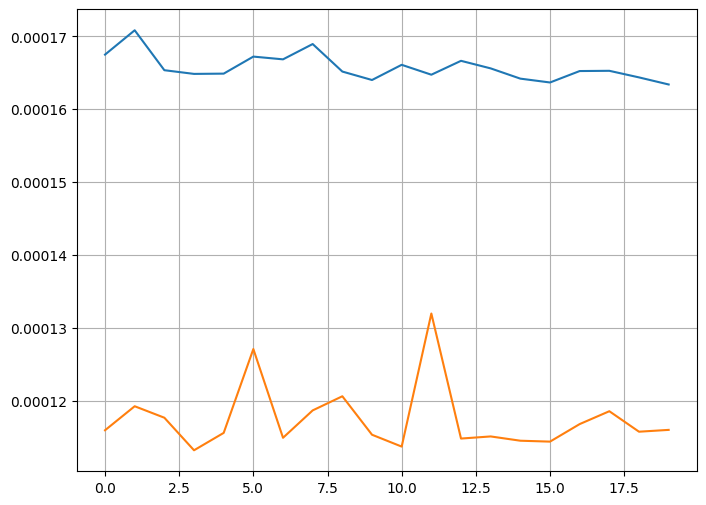

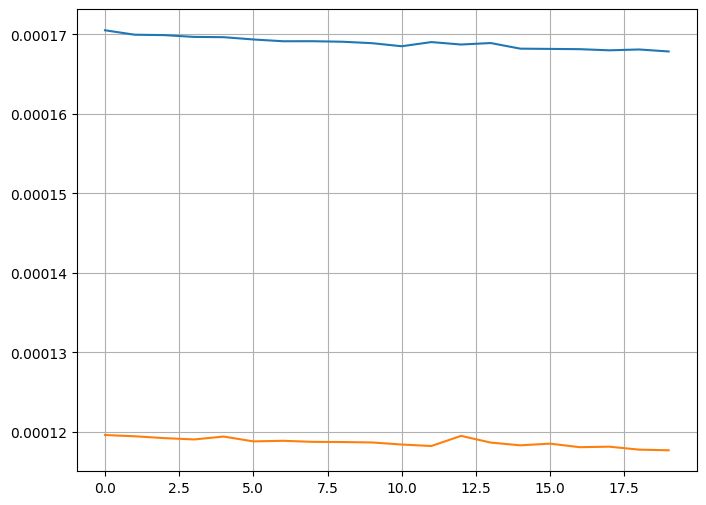

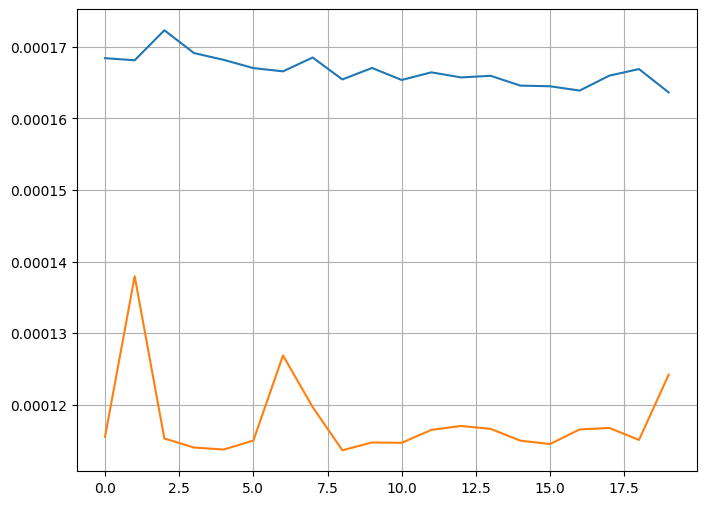

In [78]:
hist = [history1,history2,history3]

for h in hist:
  plt.plot(pd.DataFrame(h.history))
  plt.grid(True)
  plt.gca()
  plt.show()

In [79]:
for i in range(len(hist)):
  print('derniere perte du '+modN[i]+': ', round(hist[i].history['val_loss'][-1], 7))


derniere perte du model1:  0.000116
derniere perte du model2:  0.0001177
derniere perte du model3:  0.0001242


In [80]:
# choix du meilleur model

l =[]
for h in hist:
  l.append(round(h.history['val_loss'][-1],7))


meilleur_modelN = modN[l.index(min(l))]
meilleur_model = models[l.index(min(l))]

print(meilleur_modelN)

model1


#Precision

In [81]:
predicted = meilleur_model.predict(X_test_LSTM)
print(mean_squared_error(Y_test,predicted))

20/20 [==============================] - 0s 2ms/step
0.00011599218433803341


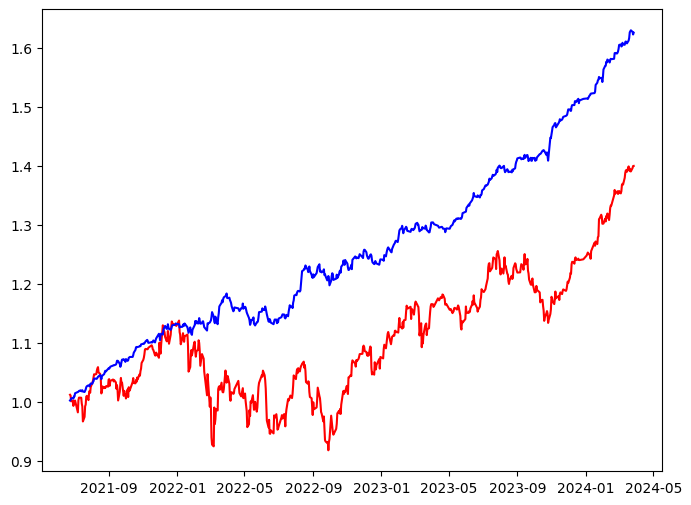

In [82]:
#comparaison predit vs reel
predicted = pd.DataFrame(predicted)
predicted.index = Y_test.index
plt.plot(np.exp(Y_test).cumprod(), 'r')
plt.plot(np.exp(predicted).cumprod(), 'b')
plt.rcParams["figure.figsize"] = (8, 6)
plt.show()